# Numerical analyses of $\kappa-sech^2$-type electron hole

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

In [50]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [195]:
T = 1
# k = 0.1
# L = 2*np.pi/k
L = 100


vmax = 10 # 速度最大值
nx = 500
nv = 500
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

## sech2分布
$$ f_u(w>0) = \frac{N_\kappa}{\sqrt{\pi\kappa\theta^2}} \left[ 1 + \frac{(\pm \sqrt{2w}+u)^2}{\kappa\theta^2} \right]^{-\kappa} $$
$$ N_\kappa = \frac{n_\infty \Gamma(\kappa)}{\Gamma(\kappa-1/2)} $$
$$ f_t(w<0) = \frac{N_\kappa}{\sqrt{\pi\kappa\theta^2}} \left( 1 - \frac{u^2}{\kappa\theta^2} \right)^{-\kappa} 
              \left[ 1-W \frac{2\kappa}{\kappa \theta^2 + u^2} 
                      \left(   1-\frac{2(\kappa+1)u^2}{\kappa\theta^2+u^2}  \right)
              \right]$$
其中$w=v^2/2-\phi$
## 理论自洽解
$$ \phi = \psi sech^2 \left(\frac{\sqrt{B_s}x}{2}\right) $$
$$ B_s = \frac{2n_\infty}{\theta^2} \left[ 1 -\frac{1}{2\kappa} + \frac{u}{\theta} Z_\kappa\left(\frac{u}{\theta}\right) \right] $$
$$ D_s = \frac{n_\infty (\kappa+1/2)(\kappa-1/2)}{\theta^4 \kappa^2 (\kappa+2)} 
            \left\{ _2F_1\left[2,2\kappa+3;\kappa+3;\frac{1}{2}(1+\frac{i}{\sqrt{\kappa}}\frac{u}{\theta})\right]
            + i \frac{\kappa+3/2}{\sqrt{\kappa}(\kappa+3)}\frac{u}{\theta} {}_2F_1\left[3,2\kappa+4;\kappa+4;\frac{1}{2}(1+\frac{i}{\sqrt{\kappa}}\frac{u}{\theta})\right]
            \right\}$$
$$ \theta = \sqrt{ \frac{\kappa-3/2}{\kappa} \frac{2T}{m} } $$

In [256]:
import mpmath as mp
mp.dps=10
# para_in = 'theta'
para_in = 'T'

def B_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1,2*kappa+2,kappa+2,z))
    zk = fac*hyp
    return 2.0/theta**2*(1.0 - 0.5/kappa + zeta*zk).real

def D_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = (kappa+0.5) * (kappa-0.5) / kappa**2 / (kappa+2.0) / theta**4
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp1 = np.complex128(mp.hyp2f1(2,2*kappa+3,kappa+3,z))
    hyp2 = 1j*(kappa+1.5)/np.sqrt(kappa)/(kappa+3)*zeta*np.complex128(mp.hyp2f1(3,2*kappa+4,kappa+4,z))
    return fac*(hyp1+hyp2).real

def E_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = 32.0*np.sqrt(2)/45.0 * sp.gamma(kappa)/sp.gamma(kappa-0.5)/np.sqrt(kappa*np.pi)/theta
    es1 = (1+zeta**2/kappa)**(-kappa-4)*(kappa+1)/kappa**3/theta**4
    es2 = (2*kappa+3)*(2*kappa+1)*zeta**4 - 6*kappa*(2*kappa+3)*zeta**2 + 3*kappa**2
    return -fac*es1*es2

def F_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac1 = (kappa+0.5)*(kappa-0.5)*(2*kappa+3)*(2*kappa+4)
    fac2 = 4*theta**6*kappa**3*(kappa+2)*(kappa+3)*(kappa+4)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp1 = np.complex128(mp.hyp2f1(4,2*kappa+5,kappa+5,z))
    hyp2 = 1j*(kappa+2.5)/np.sqrt(kappa)/(kappa+5) * zeta*np.complex128(mp.hyp2f1(5,2*kappa+6,kappa+6,z))
    return fac1/fac2 * (hyp1+hyp2).real

def B_M_nonvec(u):
    r = 1.0+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
    return r

def D_M_nonvec(u):
    r = ( (3.0-u**2)*B_M_nonvec(u)-1.0 )/4.0
    return r

def E_M_nonvec(u):
    r = -8.0/45.0/np.sqrt(np.pi)*np.exp(-u**2/2)*(u**4-6*u**2+3)
    return r

def F_M_nonvec(u):
    theta = np.sqrt(2)
    xi = u/theta
    Z = plasmapy.dispersion.plasma_dispersion_func(xi).real
    Z1 = -2*(1+xi*Z)
    Z2 = -2*(Z+xi*Z1)
    Z3 = -2*(2*Z1+xi*Z2)
    Z4 = -2*(3*Z2+xi*Z3)
    Z5 = -2*(4*Z3+xi*Z4)
    r = -Z5/384.0
    return r

B_kappa = np.vectorize(B_kappa_nonvec)
D_kappa = np.vectorize(D_kappa_nonvec)
E_kappa = np.vectorize(E_kappa_nonvec)
F_kappa = np.vectorize(F_kappa_nonvec)

B_M = np.vectorize(B_M_nonvec)
D_M = np.vectorize(D_M_nonvec)
E_M = np.vectorize(E_M_nonvec)
F_M = np.vectorize(F_M_nonvec)

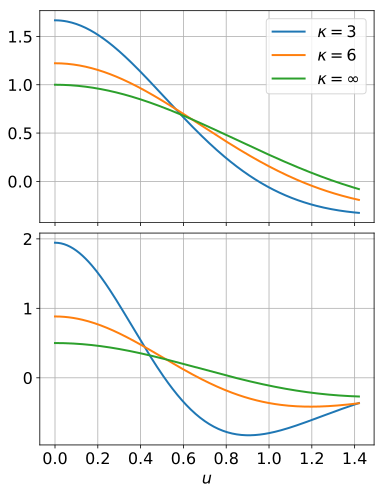

In [257]:
u = np.linspace(0.,1.42,num=200)
xticks = np.linspace(0.,1.4,num=8)

fig = plt.figure(figsize=(6,8))

ax1 = plt.subplot(211)
ax1.plot(u,B_kappa(u,3),label=r'$\kappa=3$')
ax1.plot(u,B_kappa(u,6),label=r'$\kappa=6$')
ax1.plot(u,B_M(u),label=r'$\kappa=\infty$')
ax1.legend(loc=1)
plt.xticks(xticks,())

ax2 = plt.subplot(212)
ax2.plot(u,D_kappa(u,3),label='$\kappa=3$')
ax2.plot(u,D_kappa(u,6),label='$\kappa=6$')
ax2.plot(u,D_M(u),label=r'$\kappa=\infty$')
ax2.set_xlabel(r'$u$')
plt.xticks(xticks)

[ax.grid() for ax in [ax1,ax2]]
    
# plt.legend()
# plt.axvline(1.37,linestyle=':',color='black')
plt.subplots_adjust(hspace = 0.05,wspace=0.26)
plt.show()

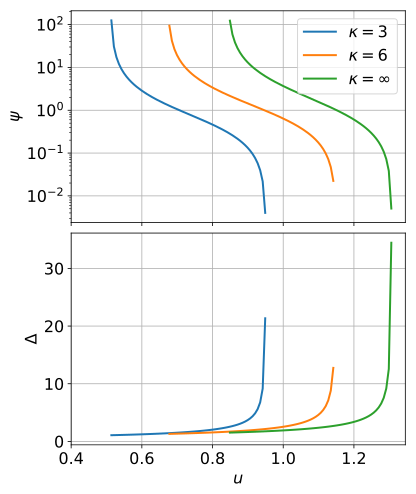

In [258]:
psi1 = -3.0*B_kappa(u,3)/D_kappa(u,3)/2.0
psi2 = -3.0*B_kappa(u,6)/D_kappa(u,6)/2.0
psi3 = -3.0*B_M(u)/D_M(u)/2.0
psi1[psi1<0] = np.nan
psi2[psi2<0] = np.nan
psi3[psi3<0] = np.nan

delta1 = np.sqrt(1.0/B_kappa(u[psi1>=0],3))
delta2 = np.sqrt(1.0/B_kappa(u[psi2>=0],6))
delta3 = np.sqrt(1.0/B_M(u[psi3>=0]))

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax1.plot(u,psi1,label=r'$\kappa=3$')
ax1.plot(u,psi2,label=r'$\kappa=6$')
ax1.plot(u,psi3,label=r'$\kappa=\infty$')
ax1.set_yscale('log')
ax1.set_ylabel(r'$\psi$')
ax1.grid()
ax1.legend(loc=1)
plt.xticks([0.4,0.6,0.8,1.0,1.2],())

ax2 = plt.subplot(212)
# ax2 = ax1.twinx()
ax2.plot(u[psi1>=0],delta1,label=r'$\kappa=3$')
ax2.plot(u[psi2>=0],delta2,label=r'$\kappa=6$')
ax2.plot(u[psi3>=0],delta3,label=r'$\kappa=\infty$')
ax2.set_xlabel(r'$u$')
ax2.set_ylabel(r'$\Delta$')
ax2.set_xticks([0.4,0.6,0.8,1.0,1.2])
# ax2.set_yscale('log')
ax2.grid()
# ax2.legend(loc=3)
plt.subplots_adjust(hspace = 0.05,wspace=0.26)
plt.show()

In [259]:
def nonvec_f_sech2(v,phi,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    r = 0
    w = v**2/2-phi
    kt2 = kappa*theta**2
    fac = math.gamma(kappa)/math.gamma(kappa-0.5)/(math.pi*kt2)**0.5
    if w>0:
        if v<=-(2*phi)**0.5:
            r=(1+(-(2*w)**0.5+u)**2/kt2)**(-kappa)
        elif v>(2*phi)**0.5:
            r=(1+( (2*w)**0.5+u)**2/kt2)**(-kappa)
    else:
        r=(1+u**2/kt2)**(-kappa) * (1-w * (2*kappa/(kt2+u**2)) * (1-2*(kappa+1)*u**2/(kt2+u**2)) )
    return fac*r
f_sech2 = np.vectorize(nonvec_f_sech2)

In [263]:
u = 0.9
kappa1 = 3
psi1 = -3.0*B_kappa(u,kappa1)/D_kappa(u,kappa1)/2.0
delta1 = np.sqrt(1.0/B_kappa(u,kappa1))
xp1 = (x-L/2)/delta1
phi1 = psi1*np.cosh(xp1)**(-2)
fv1 = f_sech2(v,psi1,kappa1)

kappa2 = 6
psi2 = -3.0*B_kappa(u,kappa2)/D_kappa(u,kappa2)/2.0
delta2 = np.sqrt(1.0/B_kappa(u,kappa2))
xp2 = (x-L/2)/delta2
phi2 = psi2*np.cosh(xp2)**(-2)
fv2 = f_sech2(v,psi2,kappa2)

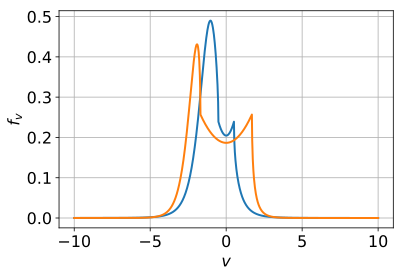

In [265]:
plt.plot(v,fv1)
plt.plot(v,fv2)
plt.xlabel(r'$v$')
plt.ylabel(r'$f_v$')
# plt.yscale('log')
plt.grid()